<a href="https://colab.research.google.com/github/rfahrn/Text-Analysis/blob/main/AnalysisAmericanCongress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Jana & Rebecka 

In [ ]:
# connect to Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Analysis of Women Speeches during War *(iraq war)* in American Congress Speeches**
---

#***Data***:

***hein-daily.zip*** and ***hein-bound.zip***from https://data.stanford.edu/congress_text#download-data Congressional Record for the 43rd-114th Congresses , the daily edition covers 97th to 114th with a time span from 1981 up to 2017, the bound edition from 1873 up to 2011



#***Hypothesis***:
We try to analysis if there is a noticible difference between topics in speech of women and men during the cold war area in congress speeches and try to dig deeper into the rhetoric of the speeches.

#***Background***: 
The cold war period was spanning from 12. März 1947 up to 26. Dezember 1991 during that time many important events happened that changed the world, like for example the proxy wars. 

Because we are using the hein-daily dataset we decided to look into iraq war (third gulf war) which evolved out of the gulf war 



---





###EDA SpeakerMap

In [ ]:
%%capture
!pip install bertopic
!pip install textstat
!pip install bertopic[flair, gensim, spacy, use]
!pip install lexicalrichness
!pip install textblob
!pip install sacremoses
!pip install Flair
!pip install cum

In [ ]:
import os
import numpy as np
import seaborn as sns
import glob
import pandas as pd
import nltk
import matplotlib as plt
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
nltk.download('stopwords')
from nltk.corpus import stopwords
from bertopic import BERTopic
from flair.embeddings import TransformerDocumentEmbeddings
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import datetime as dt

# loading the data from MyDrive 
os.chdir('/content/gdrive/')
os.chdir('/content/gdrive/MyDrive')
path = "/content/gdrive/MyDrive/hein-daily"

# concatinaging all the files of the SpeakerMaps 
all_files = glob.glob(os.path.join(path, "*SpeakerMap.txt"))
df_fs = (pd.read_csv(f,sep='|') for f in all_files)
speakersmap   = pd.concat(df_fs, axis=0, ignore_index=True)

# let's check for NAN's
speakersmap.isnull().sum()  # district     1258129 NAN's

# we won't be using district & nonvoting (voting rights) so therefore we can just delete these columns
# and we also won't be using the names because we already got their individuality by the speakerid
speakersmap.drop(['district','nonvoting','lastname','firstname'], axis=1, inplace=True)

speakersmap.head(3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,speakerid,speech_id,chamber,state,gender,party
0,107112401,1070000002,S,SD,M,D
1,107115011,1070000004,S,MS,M,R
2,107115011,1070000005,S,MS,M,R


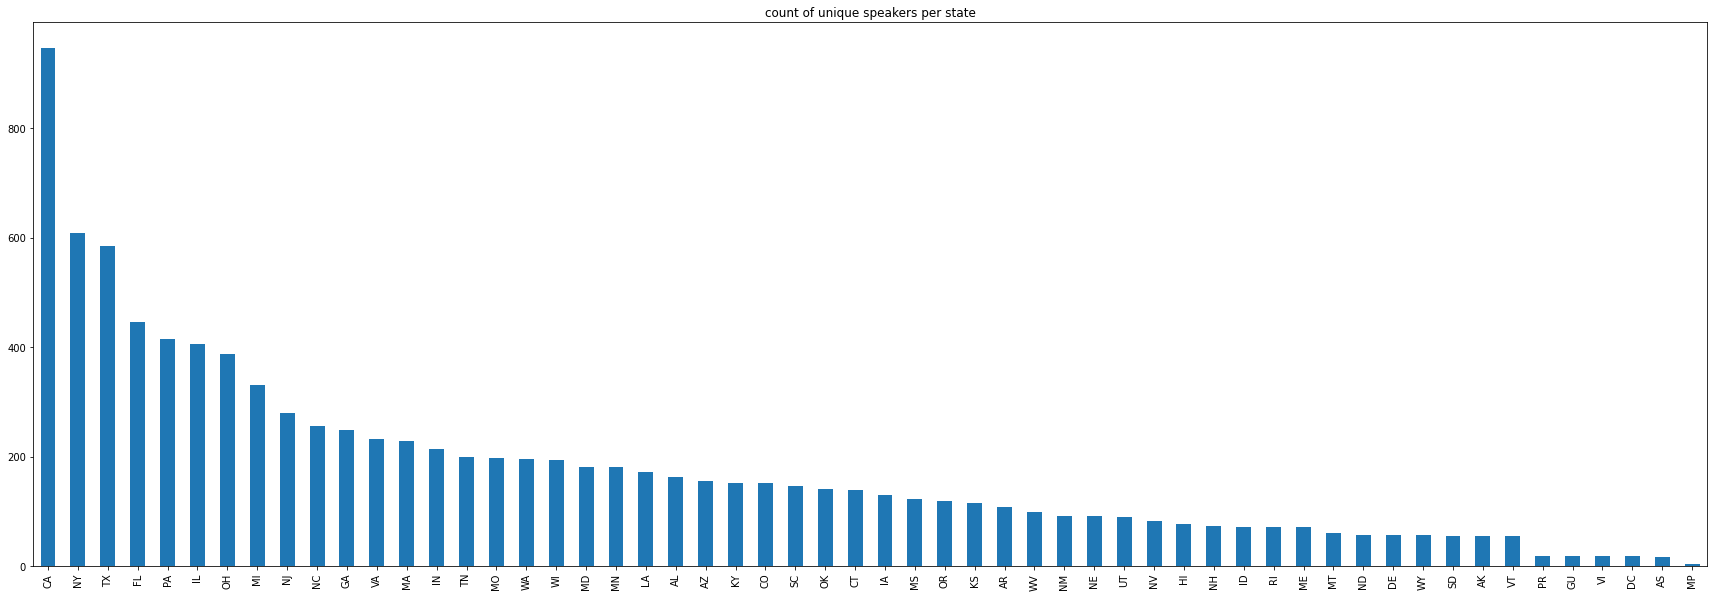

In [ ]:
speakersmap.shape  # we still have a large amount of data: 2'585'807 rows 

len(speakersmap.speech_id.unique()) # as we can see the speech_id's are unique and equal to column length of the full data

len(speakersmap.speakerid.unique()) # never the less when looking into the speakerid we can see that there are only 9'845 individuals and those individuals held 2'585'807 speeches.

len(speakersmap.state.unique())  # we have 56 states 


# now we look into how many spaekers came from what state: we see that CA
diff_speakers = speakersmap.drop_duplicates(subset=['speakerid']) 

diff_speakers.state.value_counts().plot(kind='bar',figsize=(30, 10),title="count of unique speakers per state").get_figure().savefig('count_speakers_per_state.png')


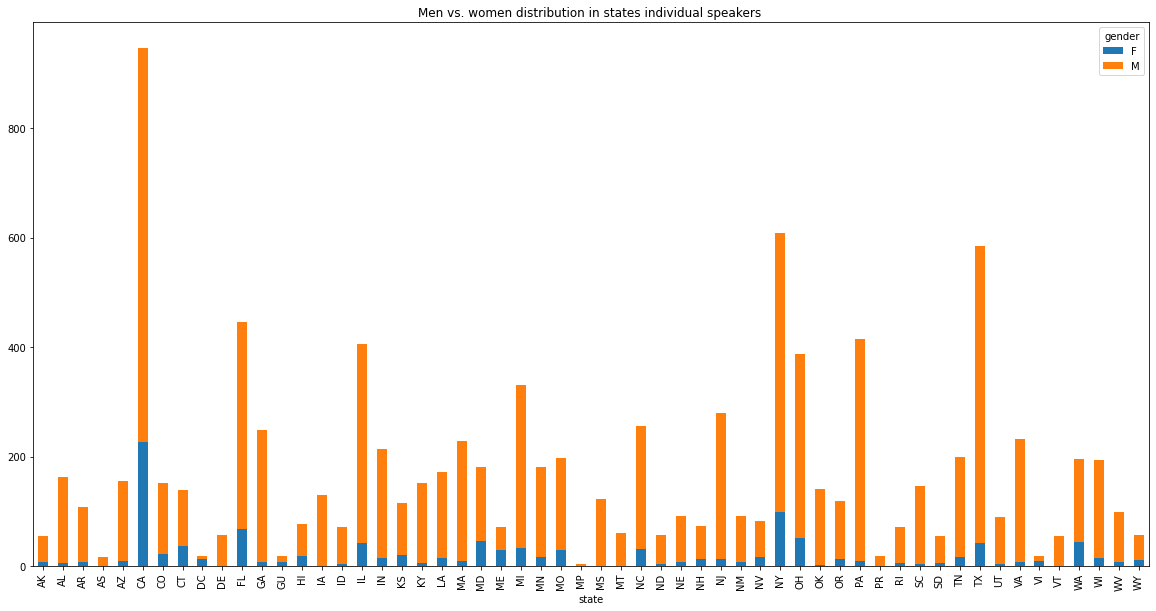

In [ ]:
diff_speakers.groupby(['state', 'gender']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='Men vs. women distribution in states individual speakers ').get_figure().savefig('count_speakers_per_state_f_vs_m.png')

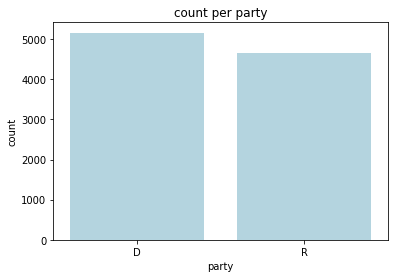

In [ ]:
diff_speakers= diff_speakers.loc[(diff_speakers['party'] == 'R') | (diff_speakers['party'] == 'D') ]
sns.countplot(diff_speakers['party'], color='lightblue').set_title('count per party')
plt.savefig('party_count.png')

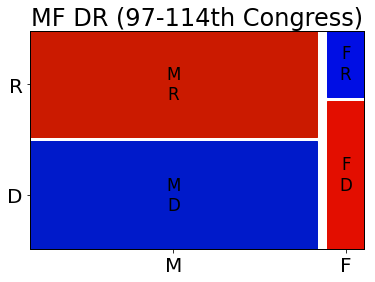

In [ ]:
# female vs. male in congress
plt.rcParams['font.size'] = 20.0
mosaic(diff_speakers,['gender', 'party'],title= 'MF DR (97-114th Congress)', gap=0.03,statistic=True)
plt.savefig('distribution_DR_vs_MF_97_114.png')
plt.show()

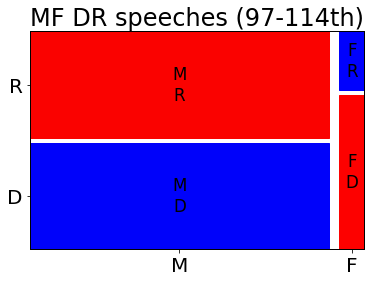

In [ ]:
# Another very interesting question how many individual speeches we have devided by party and gender:
plt.rcParams['font.size'] = 20.0
speakersmap= speakersmap.loc[(speakersmap['party'] == 'R') | (speakersmap['party'] == 'D') ]
mosaic(speakersmap,['gender', 'party'],title= 'MF DR speeches (97-114th)', gap=0.03,statistic=True)
plt.savefig('distribution_speeches_DR_vs_MF_97_114.png')
plt.show()

In [ ]:
speakersmap.shape

(2578360, 6)

In [ ]:
speakersmap.isnull().sum()

speakerid    0
speech_id    0
chamber      0
state        0
gender       0
party        0
dtype: int64

###EDA Descr-data

In [ ]:
path = "/content/gdrive/MyDrive/hein-daily"  
               
all_files = glob.glob(os.path.join(path, "descr_*.txt"))

# now there are no Nan's but they are called 'unknown' we need to filter them out
df_fs = (pd.read_csv(f,sep='|',na_values='Unknown') for f in all_files)
descr_df   = pd.concat(df_fs, axis=0, ignore_index=True)

descr_df.drop(['first_name','last_name','state','line_start','line_end','file','number_within_file'], axis=1, inplace=True)
# again there are a lot of columns we don't need (number within file , first_name,last_name,line_start, line_end, file,state, and charcount)
# we will though use the word_count to reduce the data set and only take speeches where the word count is relatively 'large'

# now let's set a condition to the word_count, so that speeches only with a certain length are considered -> this is also for our later topic modelling important.
descr_df.shape  # 3'866'183 rows we notice that it's larger than the speakersmap-dataset which had 2'585'807 rows 

descr_df.head(3)

,speech_id,chamber,date,speaker,gender,char_count,word_count
0,990000001,S,19850103,The VICE PRESIDENT,Special,298,51
1,990000002,S,19850103,The VICE PRESIDENT,Special,276,47
2,990000003,S,19850103,ber. A.D,M,1064,190


In [ ]:
# we can see that the gender is sometimes marked as 'special':
descr_df_special = descr_df[descr_df['gender']=='Special']
descr_df_special.head(8)
list_of_speaker_special = descr_df_special.speaker.unique()
print(len(list_of_speaker_special)) # 5491 individuals who are marked as special gender
list_of_speaker_special[:40] # we can see that The president and Vice and some other speakers were marked as specials, also some guests 'UNICEF' 

# Because of the already large dataset and the fact that 'only' 5491 were marked with a  special gender I decide to delete them:
# Nevertheless it can be debated/argued up on that decision, because the president probably held many important speeches and we are trying to topic model them at the end
# Another difficulty or a reason to cut them out is the fact that there are spealling differences see 'The CLERK', 'The Clerk'/'The VICE PRESIDENT', 'The VICE', we would need to check them with a regex formula and match them to set a gender or someting this is very time consuming.

5491


array(['The VICE PRESIDENT', 'The VICE', 'The legislative clerk',
       'The PRESIDENT pro tempore', 'The PRESIDING OFFICER',
       'The PRESIDENT', 'The PRESIDENTpro tempore',
       'The PRESIDING. OFFICER', 'The CLERK', 'The Clerk', 'The SPEAKER',
       'The SPEAKER pro tempore', 'The FEHBP', 'The FOIA', 'The ADEA',
       'The UNICEF', 'The ANNOUNCER', 'The SALT', 'The GATT', 'The ESOP',
       'The ACTING PRESIDENT pro tempore', 'The ACTING PRESIDENT',
       'The FISA', 'The PRESIDING', 'The MITI', 'The -PRESIDING OFFICER',
       'The FNCCI', 'The FDIC', 'The ICBM', 'The ACRS', 'The ERESIDING',
       'The CACS', 'The NCPP', 'The TOPS', 'The ACAP', 'The ACLU',
       'The CPDH', 'The PRESIDINGOFFICER', 'The AFL-CIO',
       'The assistant legislative clerk'], dtype=object)

In [ ]:
descr_df = descr_df[descr_df['gender']!='Special']
descr_df.shape

new_df = pd.merge(descr_df, speakersmap,  how='left', on=['speech_id'])
new_df.head(10) # after merging on the speech_id we have a lot of NAN's and also unequal rows because for gender_x vs gender_y, because in one data set the gender was not specified.

# we need to do some cleaning of the Nan's. 
new_df.isna().sum().sum() # there are a lot of Nan's totally: 1526649

new_df.isnull().sum() # most Nan's are in the speakerid gender party state, I decide to delete them 

new_df.dropna(inplace=True)

# now we do some cleanup of x-y gender and chamber
new_df = new_df[(new_df['gender_x']== 'M') &(new_df['gender_y']=='M') | (new_df['gender_x']== 'F') &(new_df['gender_x']=='F')]
new_df = new_df[(new_df['chamber_x']== 'R') &(new_df['chamber_y']=='R') | (new_df['chamber_x']== 'S') &(new_df['chamber_y']=='S')]

# rename and drop columns
new_df['chamber'] = new_df['chamber_x']
new_df['gender'] = new_df['gender_x']
new_df.drop(['gender_x','gender_y','chamber_x','chamber_y'], axis=1, inplace=True)



# add a column named year for later usage and better readability than date
new_df['year'] = new_df.date.astype(str).str[:4].astype(int)

new_df.shape # 1'247'645 rows, we still have a great amount of speech data and now we look more into them, as we get from word_count some speeches are very short example word_count = 9.


(1247645, 11)

We choose a threshold for the word-counts and choose as a threshold 500 words this is approximatley a speech of 2 minutes 

In [ ]:
# deletion of rows with few word_count in speeches 
# I set the threshold to be 500 words
new_df = new_df[new_df['word_count']>= 500]

In [ ]:
new_df.head()

,speech_id,date,speaker,char_count,word_count,speakerid,state,party,chamber,gender,year
16,990000052,19850103,Mr.. DOLE,3909,648,99110161.0,KS,R,S,M,1985
74,990000156,19850103,Mr. DURENBERGER,5340,926,99108211.0,MN,R,S,M,1985
77,990000160,19850103,Mr. HUMPHREY,3983,693,99107311.0,NH,R,S,M,1985
78,990000161,19850103,Mr. HUMPHREY,15404,2749,99107311.0,NH,R,S,M,1985
81,990000166,19850103,Mr. HEFLIN,11185,1874,99109161.0,AL,D,S,M,1985


now as we have the date we can finally choose the war-period we are interested in: in our case we are specifically interested in the iraq war (2003-2011) 

In [ ]:
war_df = new_df.loc[(new_df['year'] >= 2003 )& (new_df['year'] <=2011)]

In [ ]:

war_df.groupby(['state', 'gender']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='Men vs. women distribution in states of speeches during iraq war (2003-2011)').get_figure().savefig('MF_distriution_states_speeches_war_311.png')

NameError: ignored

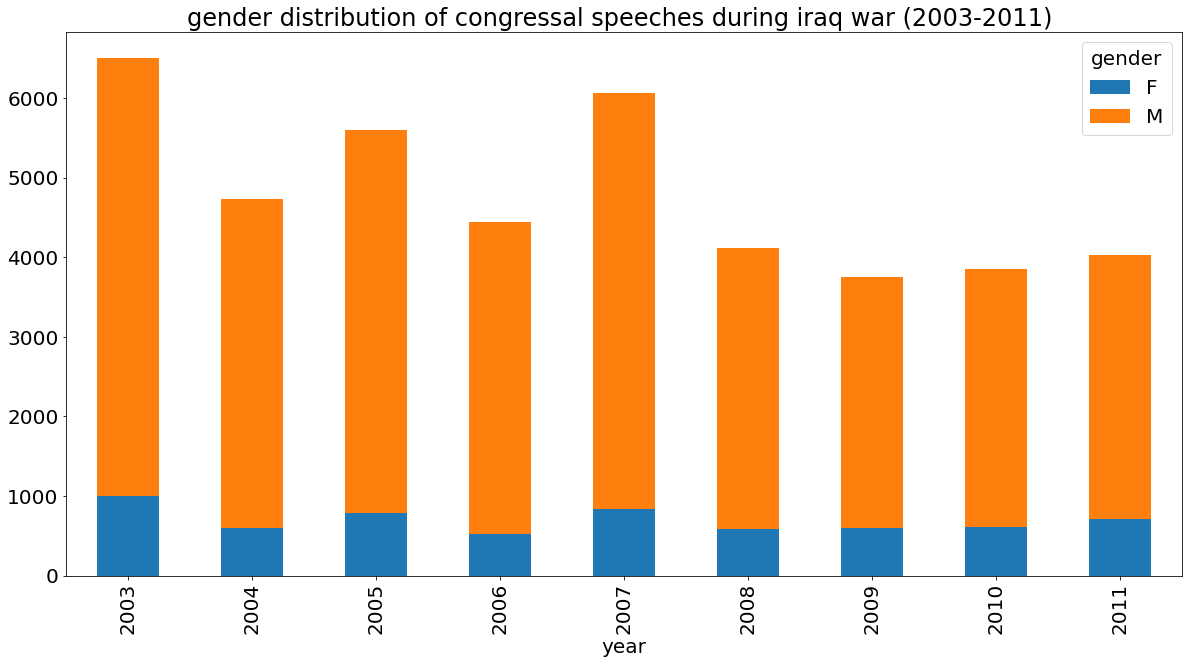

In [ ]:
war_df.groupby(['year', 'gender']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='gender distribution of congressal speeches during iraq war (2003-2011) ').get_figure().savefig('MF_distribution_congress_war.png')

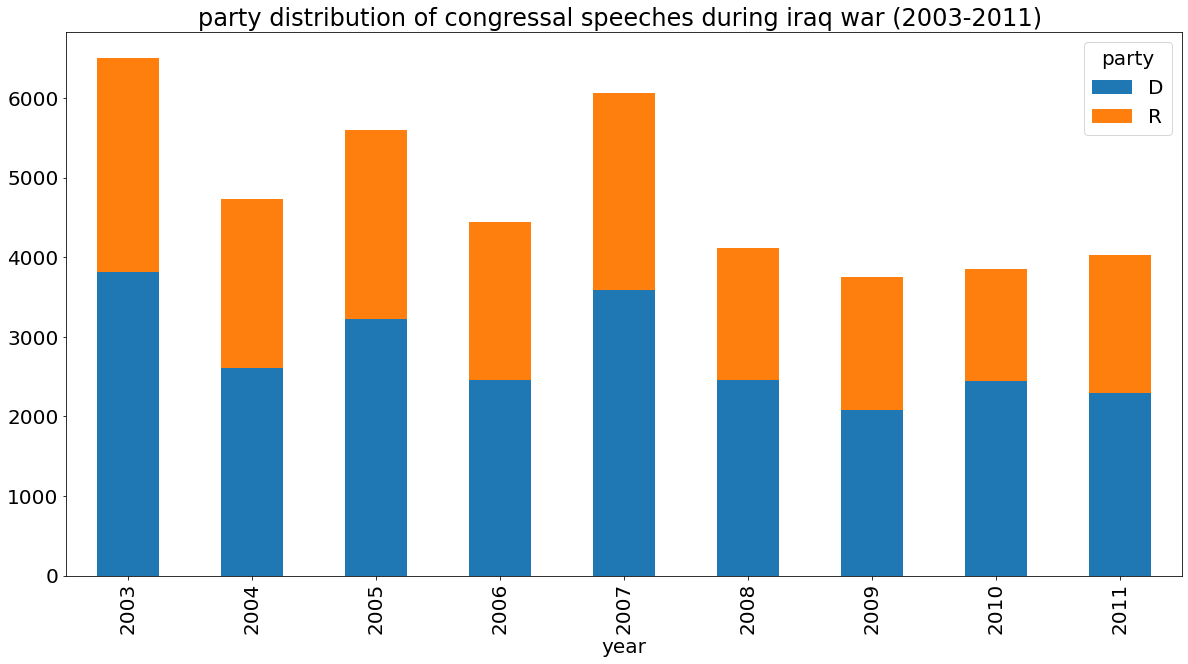

In [ ]:
war_df.groupby(['year', 'party']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10),title='party distribution of congressal speeches during iraq war (2003-2011) ').get_figure().savefig('DR_distribution_congress_war.png')

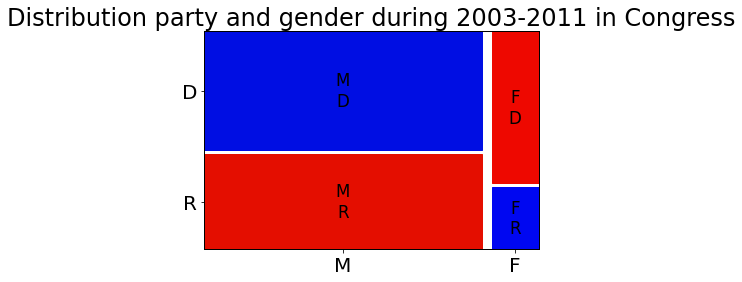

In [ ]:
plt.rcParams['font.size'] = 20.0
mosaic(war_df,['gender', 'party'],title= 'Distribution party and gender during 2003-2011 in Congress', gap=0.03,statistic=True)
plt.savefig("distribution_DR_MF_311_congress.png")
plt.show()

In [ ]:
war_df.tail(10)

,speech_id,date,speaker,char_count,word_count,speakerid,state,party,chamber,gender,year
2834573,1120080012,20111217,Mr. COCHRAN,4465,730,112118291.0,MS,R,S,M,2011
2834574,1120080013,20111217,Mr. REED,11093,1773,112118381.0,RI,D,S,M,2011
2834605,1120080073,20111217,Mr. PRYOR,3979,704,112117451.0,AR,D,S,M,2011
2834607,1120080077,20111217,Mr. MCCONNELL,4169,734,112118361.0,KY,R,S,M,2011
2834611,1120080083,20111217,Ms. LANDRIEU,20196,3520,112117431.0,LA,D,S,F,2011
2834614,1120080089,20111217,Mr. RUBIO,14171,2585,112121131.0,FL,R,S,M,2011
2834616,1120080093,20111217,Mr. SCHUMER,3988,687,112121251.0,NY,D,S,M,2011
2834632,1120080121,20111217,Mr. LEAHY,13071,2087,112120181.0,VT,D,S,M,2011
2834634,1120080125,20111217,Mr. DURBIN,8908,1439,112118321.0,IL,D,S,M,2011
2834635,1120080126,20111217,Mr. BAUCUS,3102,512,112117351.0,MT,D,S,M,2011


###EDA Speech data

The ***speeches***-data is structured in the following way:

'speeches_#nr.'
>speech_id|speech

Also here: Dataset needs to be cut in order to use it, we run out of RAM

In [ ]:
path = r"/content/gdrive/MyDrive/hein-daily"                   
files = glob.glob(os.path.join(path,  'speeches_*'))


# in order to anaylise the speeches
# preprocessing is necessairy

# getting rid of non-important speeeches for example thankyou or other very short phrases

# filter out '|' in order to make the speech-ends
# the topic -> BERTopic can be used, need to get rid of stopwords
# import fnmatch
# concatinate all Speeches form 097-114th Congress -> create dataframe 
li=[]
for file in files:
    with open(file, 'r',encoding='iso-8859-1') as temp_f: #encoding='iso-8859-1'
        # get No of columns in each line
        col_count = [ len(l.split("|")) for l in temp_f.readlines() ]
        # Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
        column_names = [i for i in range(0, max(col_count))]
        df = pd.read_csv(file, delimiter="|", names=column_names,low_memory=False,encoding='iso-8859-1')
        df  = df.iloc[: , :2]
        li.append(df)
    
frame = pd.concat(li, axis=0, ignore_index=True)
df_speeches = frame.rename(columns=frame.iloc[0]).drop(frame.index[0]) # replace header

print(df_speeches.shape) # very large -> too large -> 3'862'226 rows 

df_speeches['speech'].describe() 

In [ ]:
# check for dublicates short word speeches 
# some might be very similar 'congratualtions. ect'
df_speeches['speech'] = df_speeches['speech'].drop_duplicates()

# while concatinating some string ' headers' came into the dataframe need to delete them
df_speeches = df_speeches[df_speeches.speech_id != 'speech_id'] 

# now check for Nan's
print(df_speeches.isnull().sum())  # many speeches contain Nan's -> 121'6633 in total 

# I decide to remove the rows with contain 'unknown'/nan'-data
df_speeches = df_speeches.dropna(axis=0) 

In [ ]:
df_speeches.head(4)

In [ ]:
war_df.tail(4) # only senators 

In [ ]:
# now we need the speeches for the individual speech_id's so we merge speech_id with speech data
war_df['speech_id'] = war_df.speech_id.astype(int)
df_speeches['speech_id'] = df_speeches.speech_id.astype(int)


df = df_speeches.merge(war_df, on=['speech_id'], how='left')

# assure the correct
df = df[df['date'].between(20030101, 20110101, inclusive=True)]

df.shape # (45787, 11)

df['date'] = df.date.astype(int)
df['year'] = df.year.astype(int)
df['word_count'] = df.word_count.astype(int)
df['char_count'] = df.word_count.astype(int)
df['speakerid'] = df.speakerid.astype(int)

df.tail()

In [ ]:
rep_speech = df[df['party']=='R']
dem_speech = df[df['party']=='D']
fem_speech = df[df['gender']=='F']
mal_speech = df[df['gender']=='M']

rep_speakers = rep_speech['speakerid'].unique().tolist()
dem_speakers = dem_speech['speakerid'].unique().tolist()

# individual speakers 
len(rep_speakers)
len(dem_speakers)


print("count of male speeches: "+ str(len(mal_speech)))
print("count of female speeches: "+ str(len(fem_speech)))
print("count of democratic speeches: "+ str(len(dem_speech)))
print("count of republican speeches: "+ str(len(rep_speech)))
# we have fewer female speeches and more male speeches and more democratic speeches than republican, for topic modelling we do some random sampling and make them eaqual in size

##BERTopic

1.   First we randomly select a certain size from the dataset, because we can not train such a large amout of data with BERT
2.   Afterwards, we do some hyperparameterization of BERTopic
3.   We visualize our findings 
4.   We try to interpret our findings


We only want to compare male vs. women speeches.

In [ ]:
# we take random samples from the speeches this is due to the fact that training takes quite some time 
# this is also to make the dataset less biased towards male vs. dem speakers when topic modelling a larger dataset many more topics could arise  

rep_speech = rep_speech.sample(n=5000)
dem_speech = dem_speech.sample(n=5000)
fem_speech = fem_speech.sample(n=5000) #we only have few female speeches anyways, so we take them all. 
mal_speech = mal_speech.sample(n=5000)


# we now create 4 documents out of the 4 and do 4 individual topic modellings using bert and check for differences or similarties 
docs_rep = rep_speech['speech'].to_list()
docs_dem = dem_speech['speech'].to_list()
docs_fem = fem_speech['speech'].to_list()
docs_mal = mal_speech['speech'].to_list()

#### Hyperparameter setting


In [ ]:

# pretrained embedding model 
# roberta = TransformerDocumentEmbeddings('roberta-base') # using roBERT


# stop word removal 
stop_words = stopwords.words('english')
[stop_words.append(i) for i in ['yes','aye','no','va','our','sgt','nsf','aarp','fornia','yield','they','mr','speaker','madam','madam',
                                'amendment','oppose','chair','chairman','mister','are','mr','mrs','never','voting','forget','will','ida',
                                'mr','would','voted','000','speaker','minutes','note','pass','rules','gentleman','yea','ii','today','amend','bill'
                                ,'ask','to','claim','time','previous','question','res','we','have','our','we','the','their','and','his','is','us','he','she','agree','dr','staff','sergant','jr']]

# vectroizer use of different vectorizer 
#vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words=stop_words,lowercase = True)
vectorizer_model = TfidfVectorizer(ngram_range=(1, 2),lowercase=True, stop_words= stop_words) 

"""
# pretrained embedding model 
# roberta = TransformerDocumentEmbeddings('roberta-base')

"""

# for later training of topic models we specify the BERTopic-object and do some hypertuning/parameter settings (here we could also specify what clustering method we want to use -> defalt is umap and better than pca so i leave it )
topic_model_rep = BERTopic(verbose=True, language='English',vectorizer_model=vectorizer_model)
topic_model_dem = BERTopic(verbose=True, language='English',vectorizer_model=vectorizer_model)
topic_model_fem = BERTopic(verbose=True, language='English',vectorizer_model=vectorizer_model)
topic_model_mal = BERTopic(verbose=True, language='English',vectorizer_model=vectorizer_model)


#### Topic Models (Rep,Dem,Mal,Fem)

In [ ]:
# train topic model using tf-idf embedding in Bertopic and save model to a specific file of your choice 

#topics_rep, probs_rep = topic_model_rep.fit_transform(docs_rep)
#topic_model_rep.save('/content/gdrive/MyDrive/hein-daily/topic_model_rep_tfidf.digital') # reduced by random sample and trained with tfidfvectorizer

In [ ]:
# train topic model using tf-idf embedding in Bertopic and save model
#topics_dem, probs_dem = topic_model_dem.fit_transform(docs_dem)
#topic_model_dem.save('/content/gdrive/MyDrive/hein-daily/topic_model_dem_tfidf2.digital') # reduced by random sample and trained with tfidfvectorizer

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2022-06-25 12:50:42,553 - BERTopic - Transformed documents to Embeddings
2022-06-25 12:51:07,004 - BERTopic - Reduced dimensionality
2022-06-25 12:51:07,243 - BERTopic - Clustered reduced embeddings


In [ ]:
# train topic model using tf-idf embedding in  Bertopic and save model 
#topics_fem, probs_fem = topic_model_fem.fit_transform(docs_fem)
#topic_model_fem.save('/content/gdrive/MyDrive/hein-daily/topic_model_fem_tfidf2.digital') # # reduced by random sample and trained with tfidfvectorizer

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2022-06-25 11:45:54,280 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-06-25 11:46:23,732 - BERTopic - Reduced dimensionality
2022-06-25 11:46:23,942 - BERTopic - Clustered reduced embeddings


In [ ]:
# train topic model using tf-idf embedding in Bertopic and save model
#topics_mal, probs_mal = topic_model_mal.fit_transform(docs_mal)
#topic_model_mal.save('/content/gdrive/MyDrive/hein-daily/topic_model_mal_tfidf2.digital') # reduced by random sample and trained with tfidfvectorizer

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2022-06-25 12:08:42,506 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-06-25 12:09:10,372 - BERTopic - Reduced dimensionality
2022-06-25 12:09:10,587 - BERTopic - Clustered reduced embeddings


In [ ]:
from bertopic import BERTopic
# load trained topic model , so that we don't have to train it again from scratch 
# trained using TfidfVectorizer: vectorizer_model = TfidfVectorizer(ngram_range=(1, 3),lowercase=True, stop_words= stop_words) 
#topic_model_rep = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_rep_tfidf.digital')
#topic_model_dem = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_dem_tfidf2.digital')
#topic_model_fem = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_fem_tfidf2.digital')
#topic_model_mal = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_mal_tfidf2.digital')


# trained using CountVectorizer: #vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)
#topic_model_rep = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_rep.digital')
#topic_model_dem = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_dem.digital')
#topic_model_fem = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_fem.digital')
#topic_model_mal = BERTopic.load('/content/gdrive/MyDrive/hein-daily/topic_model_mal.digital')

####Reuslts: Visualizations


#####Top Word Scores

######Female

In [ ]:
topic_model_fem.get_topic_info()

,Topic,Count,Name
0,-1,1203,-1_people_senator_energy_going
1,0,168,0_disaster_sba_fema_louisiana
2,1,142,1_students_education_school_pell
3,2,123,2_medicare_seniors_prescription_drug
4,3,108,3_health_insurance_care_health care
...,...,...,...
97,96,11,96_kagan_solicitor_solicitor general_general k...
98,97,11,97_hiv_aids_hiv aids_toto
99,98,11,98_peace corps_corps volunteers_volunteers_youth
100,99,11,99_science_atp_science parks_math


In [ ]:
topic_model_fem.get_topic(7)

[('iraq', 0.016888837772097338),
 ('troops', 0.01358592061360634),
 ('iraqi', 0.010524775388316374),
 ('war', 0.008117397688606164),
 ('iraqis', 0.0067613719484953955),
 ('iraqi government', 0.005401971541997431),
 ('iraqs', 0.004181590524146991),
 ('baghdad', 0.004077745118728073),
 ('surge', 0.003992950836827038),
 ('president', 0.003992399778167806)]

In [ ]:
topic_model_fem.visualize_barchart(top_n_topics=10, n_words=5)

######Male

In [ ]:
topic_model_mal.get_topic_info()

,Topic,Count,Name
0,-1,1531,-1_president_people_senate_senator
1,0,312,0_oil_energy_gas_renewable
2,1,210,1_paul_senate_ted_senator
3,2,142,2_military_defense_iraq_troops
4,3,141,3_amendments_senator_vote_senate
...,...,...,...
89,88,11,88_estate_estate tax_death tax_tax
90,89,10,89_personal data_data_privacy_information
91,90,10,90_public corruption_corruption_investigators ...
92,91,10,91_taxpayer identification_contractors_batsa_c...


In [ ]:
topic_model_mal.get_topic(4)

[('iraq', 0.015923883998381558),
 ('iraqi', 0.010223872195426406),
 ('troops', 0.00963213972702319),
 ('war', 0.006304716622304443),
 ('iraqis', 0.005822157829259863),
 ('president', 0.0043285814780986975),
 ('alqaida', 0.004301477967007756),
 ('saddam', 0.004201778154954172),
 ('military', 0.003970996843108207),
 ('petraeus', 0.003915285743494411)]

In [ ]:
topic_model_mal.visualize_barchart(top_n_topics=10, n_words=5)

######Democrates

In [ ]:
topic_model_dem.get_topic_info()# shows topics their associated name and their frequency=count over the whole doc

,Topic,Count,Name
0,-1,1547,-1_people_president_senator_one
1,0,226,0_byrd_senator_senate_coach
2,1,151,1_nominees_judge_circuit_court
3,2,136,2_medicare_drug_seniors_prescription
4,3,122,3_iraq_troops_iraqi_iraqis
...,...,...,...
86,85,11,85_stimulus_stimulus package_package_food
87,86,11,86_bankruptcy_homestead_homestead exemption_de...
88,87,11,87_cribs_product safety_products_consumer product
89,88,11,88_tile_senate_senator_republican


In [ ]:
topic_model_dem.get_topic(9) # words that make the topic and their probability 

[('iraq', 0.007775239368105233),
 ('troops', 0.005942430450728137),
 ('war', 0.004993439561655027),
 ('billion', 0.004969831131223204),
 ('defense', 0.004785550120129752),
 ('supplemental', 0.0042020588528277085),
 ('military', 0.003725332442189358),
 ('halliburton', 0.0035001163837069015),
 ('budget', 0.003458204847811914),
 ('reconstruction', 0.0031916654669923335)]

In [ ]:
topic_model_dem.visualize_barchart(top_n_topics=10, n_words=5)

######Republicans

In [ ]:
topic_model_rep.get_topic_info()

,Topic,Count,Name
0,-1,1611,-1_people_president_one_tax
1,0,367,0_energy_oil_gas_ethanol
2,1,190,1_iraq_iraqi_troops_iraqis
3,2,173,2_border_immigration_amnesty_illegal
4,3,161,3_patent_pto_amendments_going
...,...,...,...
95,94,11,94_im thankful_thankful_ettels_im
96,95,11,95_corps_projects_million_corps engineers
97,96,11,96_pickering_brown_segregation_board education
98,97,10,97_attorney general_mathews_court claims_wolski


In [ ]:
topic_model_rep.get_topic(1) 

[('iraq', 0.010946791251729445),
 ('iraqi', 0.0069391146222326),
 ('troops', 0.004021322014813767),
 ('iraqis', 0.004004225273048631),
 ('baghdad', 0.0036581439619673816),
 ('petraeus', 0.003455469728197913),
 ('saddam', 0.0033887578297773263),
 ('war', 0.0031788175125787863),
 ('general petraeus', 0.0029925757566501322),
 ('alqaida', 0.002651804157060224)]

In [ ]:
topic_model_rep.visualize_barchart(top_n_topics=10, n_words=5)

#####Intertopic Distance Map


######Female

In [ ]:
topic_model_fem.visualize_topics()

######Male

In [ ]:
topic_model_mal.visualize_topics()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


######Democrates

In [ ]:
topic_model_dem.visualize_topics()

######Republicans

In [ ]:
topic_model_rep.visualize_topics()

#####Hierarchical Clusters of Topics

######Female

In [ ]:
topic_model_fem.visualize_hierarchy(topics=[0,7,3,6,8])

######Male

In [ ]:
topic_model_mal.visualize_hierarchy(topics=[0,7,2,4,9,8])

######Democrates

In [ ]:
topic_model_dem.visualize_hierarchy(topics=[3,6,5,4,9])

######Republicans

In [ ]:
topic_model_rep.visualize_hierarchy(topics=[0,1,3,4,8])

#####**Similarity** Matrix


######Female

In [ ]:
# similarity heatmap
topic_model_fem.visualize_heatmap(topics =[0,7,3,6,8])

######Male

In [ ]:
# similarity heatmap
topic_model_mal.visualize_heatmap(topics=[0,7,2,0,4,9])

######Democrates

In [ ]:
# similarity heatmap
topic_model_dem.visualize_heatmap(topics =[0,1,3,4,8])

######Republicans

In [ ]:
# similarity heatmap
topic_model_rep.visualize_heatmap(topics =[0,1,3,4,8])

#####Topic over Time



In [ ]:
from time import time
# get timestamp
def get_timestamp(df):
  df['time'] = pd.to_datetime(df.date,format='%Y%m%d')
  list_timestamps = df['date'].to_list()
  time_list = df.time.to_list()
  spee = df.speech.to_list()
  return time_list

time_list_dem = get_timestamp(dem_speech)
time_list_rep = get_timestamp(rep_speech)
time_list_fem = get_timestamp(fem_speech)
time_list_mal = get_timestamp(mal_speech)

######Female

In [ ]:
topics_over_time_fem = topic_model_fem.topics_over_time(docs_fem,
                                                   topics_fem,
                                                   time_list_fem,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )

50it [07:19,  8.78s/it]


In [ ]:
topic_model_fem.visualize_topics_over_time(topics_over_time_fem, topics=[0,7,3,2,6,8],normalize_frequency = True)

NameError: ignored

######Male

In [ ]:
topics_over_time_mal = topic_model_mal.topics_over_time(docs_mal,
                                                   topics_mal,
                                                   time_list_mal,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )

50it [09:24, 11.30s/it]


In [ ]:
topic_model_mal.visualize_topics_over_time(topics_over_time_mal, topics=[0,7,2,0,4],normalize_frequency = True)

######Democrates

In [ ]:
topics_over_time_dem = topic_model_dem.topics_over_time(docs_dem,
                                                   topics_dem,
                                                   time_list_dem,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )

In [ ]:
topic_model_dem.visualize_topics_over_time(topics_over_time_dem, top_n_topics=2)

######Republicans


In [ ]:
topics_over_time_rep = topic_model_rep.topics_over_time(docs_rep,
                                                   topics_rep,
                                                   time_list_rep,
                                                   nr_bins=50,
                                                   datetime_format="%Y-%m-%d"
                                                )

In [ ]:
topic_model_rep.visualize_topics_over_time(topics_over_time_rep, topics=[2,1,3],normalize_frequency = True)

##Speech Complexity


In [ ]:
# compute character word count ratio 

df["cwc_ratio"] = df["char_count"] / df["word_count"]

In [ ]:
df.head(4)

,speech_id,speech,date,speaker,char_count,word_count,speakerid,state,party,chamber,gender,year,cwc_ratio
1889401,1080000311,Mr. President. I rise today in support of exte...,20030107,Mr. GRASSLEY,509,509,108119591,IA,R,S,M,2003,1.0
1889402,1080000312,Mr. President. I am pleased to join my colleag...,20030107,Mr. SARBANES,979,979,108113281,MD,D,S,M,2003,1.0
1889404,1080000314,Mr. President. I rise today to urge the Senate...,20030107,Mr. FITZGERALD,657,657,108112451,IL,R,S,M,2003,1.0
1889417,1080000334,Mr. President. reservIng the right to object. ...,20030107,Mr. BAUCUS,527,527,108117351,MT,D,S,M,2003,1.0


In [ ]:
import textstat
from lexicalrichness import LexicalRichness
import matplotlib.patches as patches

def apply_gunning_fog(data):
    '''
    Uses syllables.
    
    Select multi-sentence segment of 100 words. 
    Index = 0.4 * ((average sentence length) + 100 * (complex words / words))
    average sentence length = number of words (in multi-sentence segment) per number of sentences 
    complex words: consisting of three syllables or more, no proper nouns, no familiar jargon, no compound words; common suffixes (e.g. -ed) are not included as syllable
    
    Index value indicates education level necessary to comprehend text (6: Sixth grader, 17: College graduate)
    '''
    return textstat.gunning_fog(data["speech"])

def apply_coleman_liau(data):
    '''Character-based'''
    return textstat.coleman_liau_index(data["speech"])


def apply_dugast(data):
    '''
    The higher the value the more lexically rich. 
    (In contrast, for Maas index, the lower the more diverse.)
    '''
    
    lex = LexicalRichness(data["speech"])
    try: # exception occurs when word count and term counts are the same.
        dugast = lex.Dugast
    except Exception:
        dugast = np.nan 
        
    return dugast

# complexity/ readability
df["gunning_fog"] = df.apply(apply_gunning_fog, axis = 1) # syllable-based 
df["coleman_liau"] = df.apply(apply_coleman_liau, axis = 1)# character-based

# lexical richness 
df["dugast"] = df.apply(apply_dugast, axis = 1) 


# show 
df.head(6)

,speech_id,speech,date,speaker,char_count,word_count,speakerid,state,party,chamber,gender,year,cwc_ratio,gunning_fog,coleman_liau,dugast
1889401,1080000311,Mr. President. I rise today in support of exte...,20030107,Mr. GRASSLEY,509,509,108119591,IA,R,S,M,2003,1.0,8.76,11.12,57.558150
1889402,1080000312,Mr. President. I am pleased to join my colleag...,20030107,Mr. SARBANES,979,979,108113281,MD,D,S,M,2003,1.0,7.38,9.61,49.001098
1889404,1080000314,Mr. President. I rise today to urge the Senate...,20030107,Mr. FITZGERALD,657,657,108112451,IL,R,S,M,2003,1.0,16.33,12.36,55.764830
1889417,1080000334,Mr. President. reservIng the right to object. ...,20030107,Mr. BAUCUS,527,527,108117351,MT,D,S,M,2003,1.0,7.23,6.99,44.939685
1889447,1080000379,Mr. President. I thank my assistant Democratic...,20030107,Mrs. BOXER,824,824,108118701,CA,D,S,F,2003,1.0,5.83,5.01,46.725886
1889448,1080000381,Mr. President. I have been here throughout thi...,20030107,Mr. THOMAS,661,661,108115211,WY,R,S,M,2003,1.0,6.36,5.14,40.775605


#####Plotting

Using 95% confidence interval

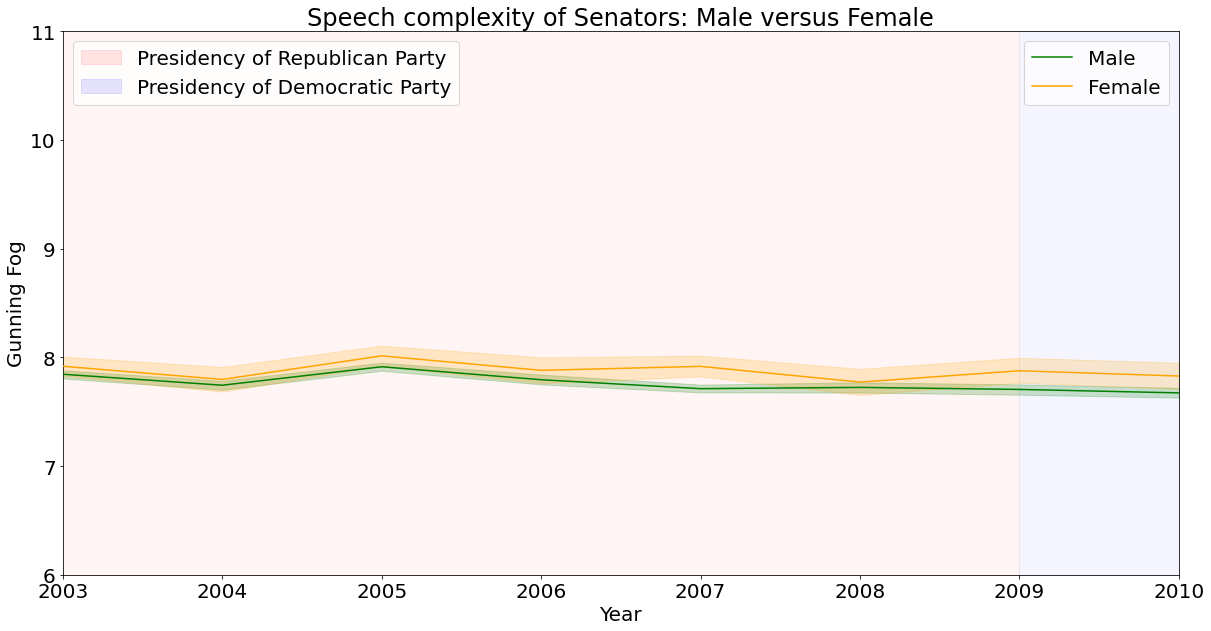

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = df[df["chamber"].isin(["S"])], x="year", y="gunning_fog", hue ="gender", palette = {"M":"green","F":"orange"}, zorder = 10, ax = ax)

# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 7, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(2003, 2010))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Male")
legend.get_texts()[1].set_text("Female")

# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

# Title
plt.title("Speech complexity of Senators: Male versus Female") 
plt.savefig('Speech_complexity_genders.png')
plt.show()


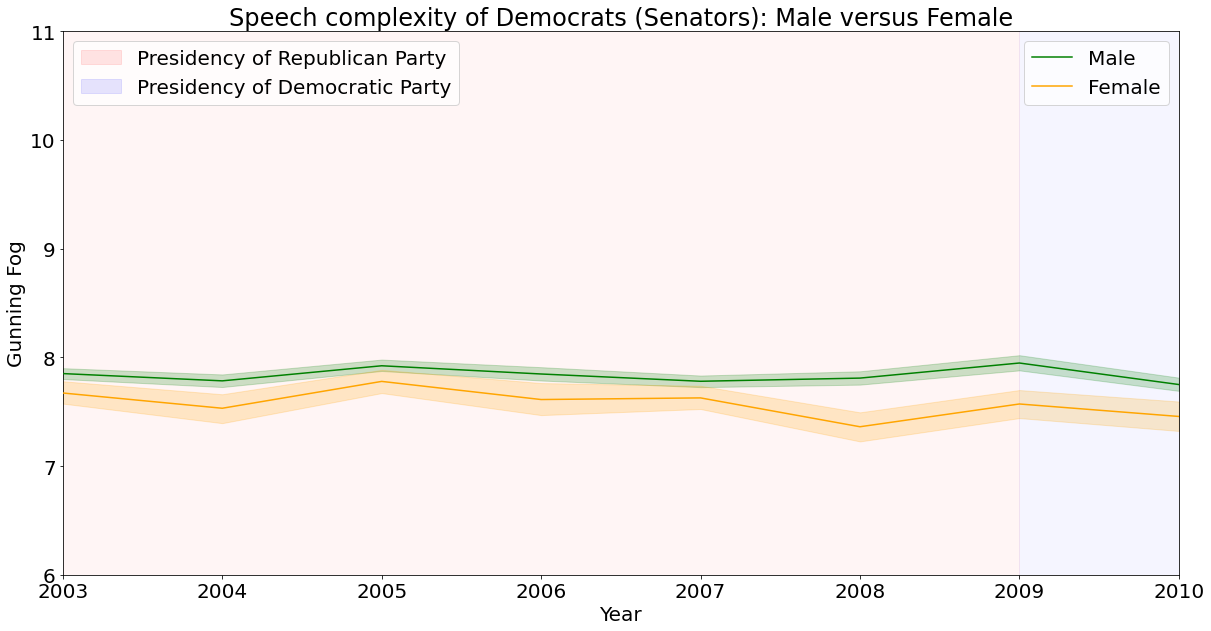

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = df[df["party"].isin(["D"])], x="year", y="gunning_fog", hue ="gender", palette = {"M":"green","F":"orange"}, zorder = 10, ax = ax)

# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 7, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(2003, 2010))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Male")
legend.get_texts()[1].set_text("Female")

# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

# Title
plt.title("Speech complexity of Democrats (Senators): Male versus Female") 
plt.savefig('Speech_complexity_genders_dem.png')
plt.show()


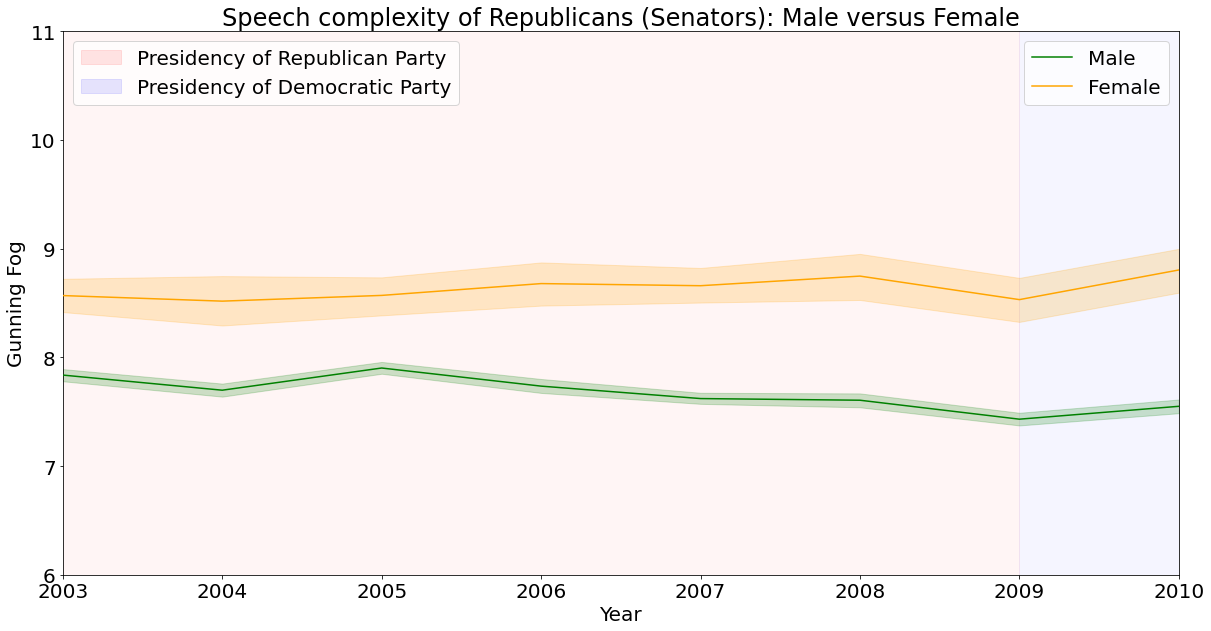

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = df[df["party"].isin(["R"])], x="year", y="gunning_fog", hue ="gender", palette = {"M":"green","F":"orange"}, zorder = 10, ax = ax)

# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 7, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(2003, 2010))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Male")
legend.get_texts()[1].set_text("Female")

# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

# Title
plt.title("Speech complexity of Republicans (Senators): Male versus Female") 
plt.savefig('Speech_complexity_genders_rep.png')
plt.show()


In [ ]:
by_gender_means = df[df["chamber"].isin(['S'])].groupby("gender").mean()["gunning_fog"].reset_index()
by_gender_means = by_gender_means.append(by_gender_means)
by_gender_means["year"] = [1981,1981,2016,2016]

by_gender_means.head(3)

,gender,gunning_fog,year
0,F,7.885872,1981
1,M,7.773241,1981
0,F,7.885872,2016


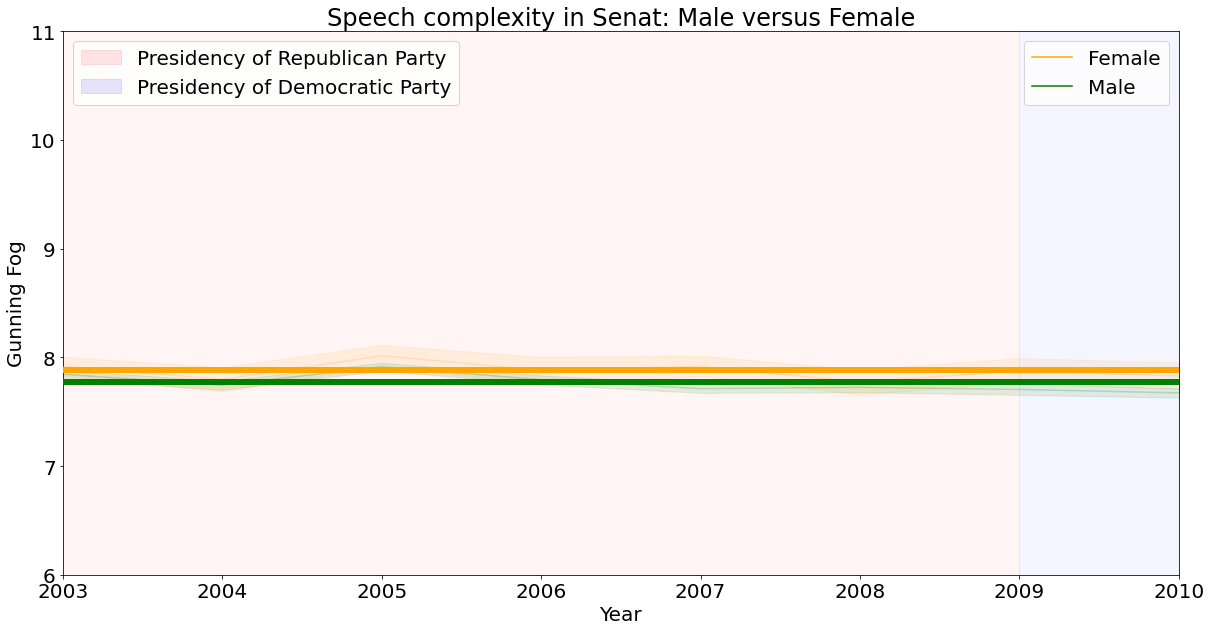

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = df[df["chamber"].isin(["S"])], x="year", y="gunning_fog", hue ="gender", palette = {"M":"green","F":"orange"}, zorder = 10, legend = False, alpha = 0.2, err_kws={"alpha": .1}, ax = ax)
sns.lineplot(data = by_gender_means.reset_index(drop=True), x = "year", y= "gunning_fog", hue = "gender", palette = {"M":"green","F":"orange"}, linewidth = 6, zorder = 12, ax = ax)


# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 7, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 7, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 7, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(2003, 2010))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Female")
legend.get_texts()[1].set_text("Male")

# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)

# Title
plt.title("Speech complexity in Senat: Male versus Female")
plt.savefig('Speech_complexity_genders_mean.png')

plt.show()



In [ ]:
from scipy import stats
mal_vals = df[df["gender"] == "M"]["gunning_fog"].values
fem_vals = df[df["gender"] == "F"]["gunning_fog"].values

print("Variance male sample:", np.var(mal_vals), "\nVariance female sample:", np.var(fem_vals) )

print("\nT-Test for difference of 'Gunning Fog' means, full time-frame, male vs female")
print("Assuming different variance")
t_test = stats.ttest_ind(mal_vals,fem_vals,equal_var = False)
alpha=0.05
print("p-value:", t_test[1])
if(t_test[1] < alpha):
    print("Sample means are significantly different!")
else:
    print("Sample means are not significantly different!")

Variance male sample: 1.8900223256512492 
Variance female sample: 2.0601548854624356

T-Test for difference of 'Gunning Fog' means, full time-frame, male vs female
Assuming different variance
p-value: 6.308815633647553e-08
Sample means are significantly different!


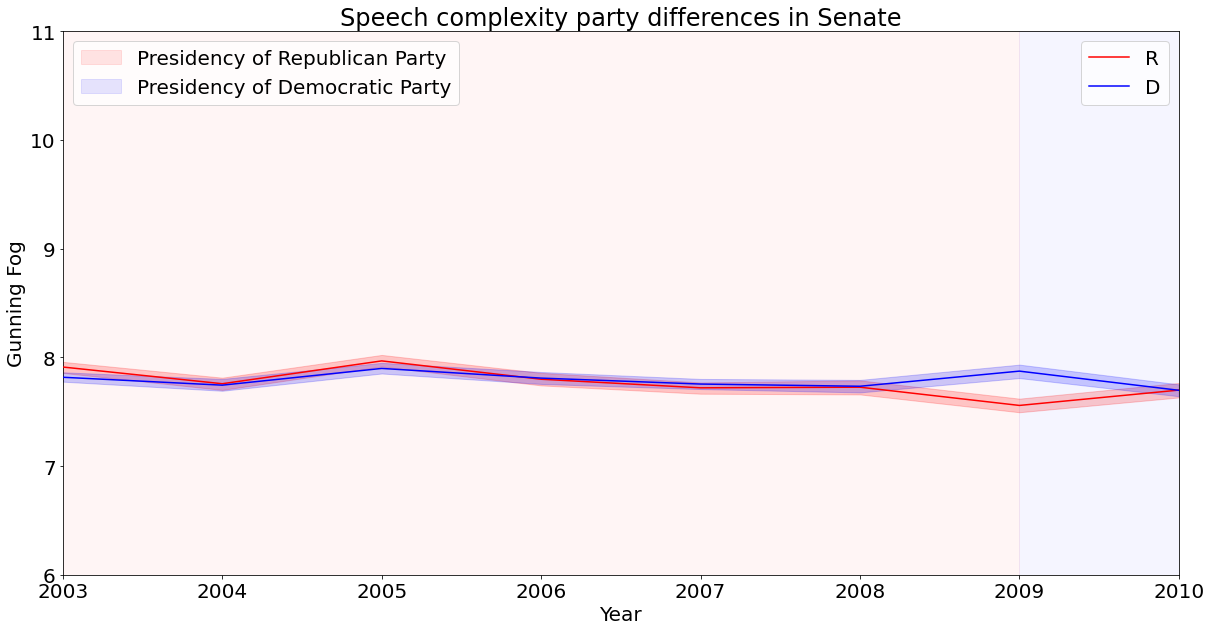

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = df[df["party"].isin(["R","D"])], x="year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, ax = ax)

# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(2003, 2010))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("R")
legend.get_texts()[1].set_text("D")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)


plt.title("Speech complexity party differences in Senate")
plt.savefig('Speech_complexity_party_senate.png')
plt.show()

overall mean

In [ ]:
by_party_means = df[df["party"].isin(["R","D"])].groupby("party").mean()["gunning_fog"].reset_index()
by_party_means = by_party_means.append(by_party_means)
by_party_means["year"] = [1981,1981,2016,2016]

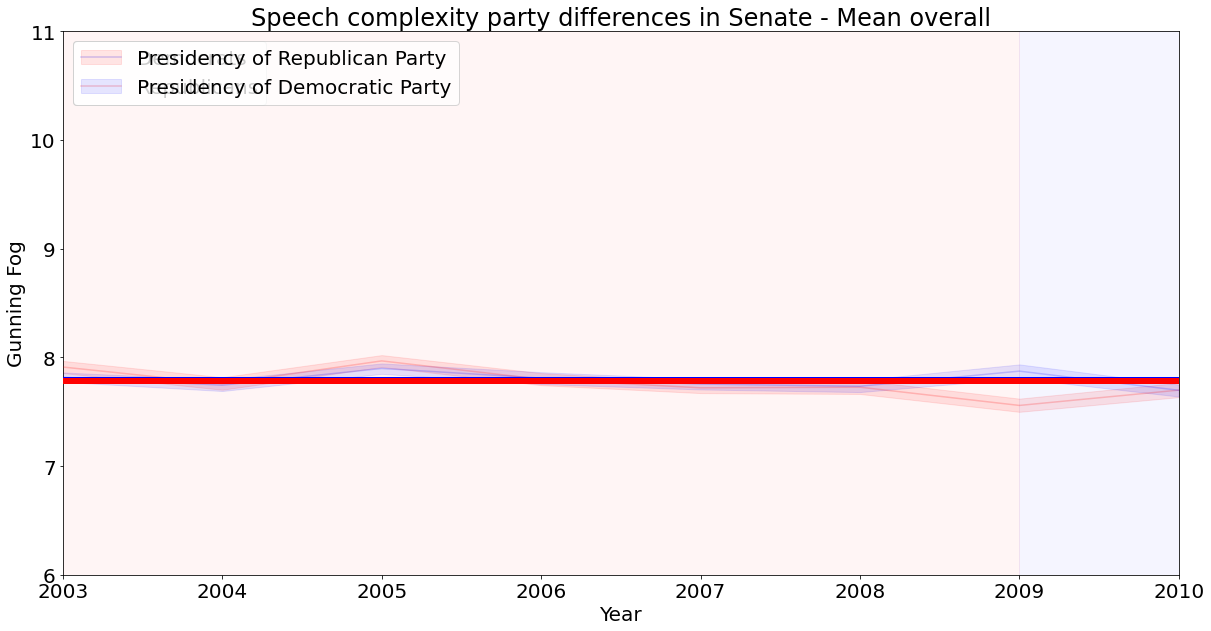

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data = df[df["party"].isin(["R","D"])], x="year", y="gunning_fog", hue ="party", palette = {"R":"red","D":"blue"}, zorder = 10, legend = False, alpha = 0.2, err_kws={"alpha": .1}, ax = ax)
sns.lineplot(data = by_party_means.reset_index(drop=True), x = "year", y= "gunning_fog", hue = "party", palette = {"R":"red","D":"blue"}, linewidth = 6, zorder = 12, ax = ax)

# Add presidencies
rect_1 = patches.Rectangle((1981, 6), 8, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_2 = patches.Rectangle((1989, 6), 4, 5, linewidth=1, edgecolor='r', facecolor='red', alpha = 0.04, zorder = 0)
rect_3 = patches.Rectangle((1993, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
rect_4 = patches.Rectangle((2001, 6), 8, 5, linewidth=1, edgecolor='red', facecolor='red', alpha = 0.04, zorder = 0)
rect_5 = patches.Rectangle((2009, 6), 8, 5, linewidth=1, edgecolor='blue', facecolor='blue', alpha = 0.04, zorder = 0)
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(rect_5)

# Clean up look 
ax.set(xlim=(2003, 2010))
ax.set(ylim=(6, 11))
ax.set_ylabel("Gunning Fog")
ax.set_xlabel("Year")
legend=ax.legend()
legend.get_texts()[0].set_text("Democrats")
legend.get_texts()[1].set_text("Republicans")


# Store current legend 
other_legend = ax.get_legend()

# Add presidency legend
legend_elements = [patches.Patch(facecolor='red', alpha = 0.1, edgecolor='r',
                         label='Presidency of Republican Party'),
                   patches.Patch(facecolor='blue', alpha = 0.1, edgecolor='b',
                         label='Presidency of Democratic Party')]
ax.legend(handles=legend_elements, loc='upper left')

# Add back previous legend
ax.add_artist(other_legend)


plt.title("Speech complexity party differences in Senate - Mean overall")
plt.savefig('Speech_complexity_party_mean.png')

plt.show()